# Performing a basic analysis - Normalised Burn Ratio

### Load packages
* 'sys' provdies access to helpful support functions in the 'dea_plotting' module.
* 'datacube' provides the ability to query and load data.
* 'matplotlib' provides the ability to format and manipulate plots.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
from datacube.helpers import write_geotiff
import matplotlib.gridspec as gridspec

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_plotting import rgb

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='basic_nbr')

### Step 1: Choose a study area

In [3]:
# Set the central latitude and longitude
central_lat = -30.813075
central_lon = 152.207625

# Set the buffer to load around the central coordinates
buffer = 0.05

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Step 2: Loading data

In [4]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2a_ard_granule"

# Set the date range to load data over
set_time = ("2019-09-01", "2019-11-01")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "nbar_red",
    "nbar_blue",
    "nbar_green",
    "nbar_nir_1",
    "nbar_swir_2"
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
set_crs = "epsg:3577"
set_resolution = (-10, 10)

# Load the dataset
dataset = dc.load(
    product=set_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    output_crs=set_crs,
    resolution=set_resolution,
    #resampling="average"
)

print(dataset)

<xarray.Dataset>
Dimensions:      (time: 11, x: 1113, y: 1257)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-02T00:02:41.024000 ... 2019-11-01T00:02:41.024000
  * y            (y) float64 -3.499e+06 -3.499e+06 ... -3.512e+06 -3.512e+06
  * x            (x) float64 1.9e+06 1.9e+06 1.9e+06 ... 1.911e+06 1.911e+06
Data variables:
    nbar_red     (time, y, x) int16 151 217 242 205 177 ... 446 409 428 449 471
    nbar_blue    (time, y, x) int16 146 192 205 170 160 ... 493 476 493 495 498
    nbar_green   (time, y, x) int16 168 250 293 206 246 ... 512 476 482 498 518
    nbar_nir_1   (time, y, x) int16 1041 1281 1395 1036 ... 1757 1855 1785 2005
    nbar_swir_2  (time, y, x) int16 866 866 876 876 813 ... 1049 1049 1128 1128
Attributes:
    crs:      epsg:3577


### Step 3: Plotting the data

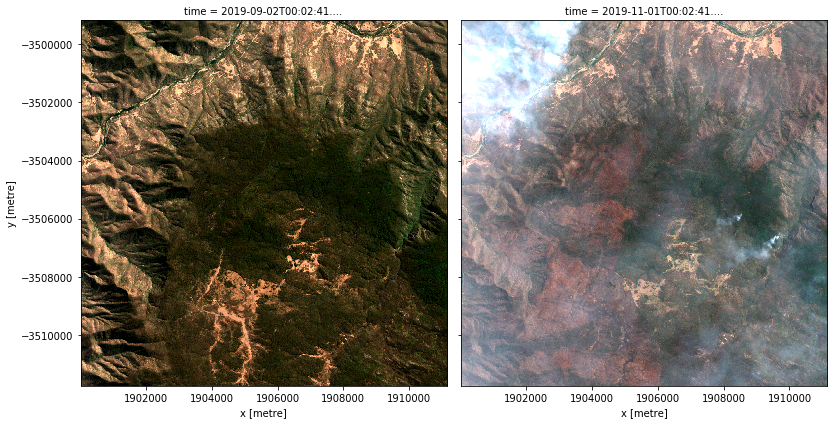

In [5]:
# Set the time step to view
#time_step = 0

# Set the band combination to plot
bands = ["nbar_red", "nbar_green", "nbar_blue"]

# Generate the image by running the rgb function
rgb(dataset, bands=bands, index=[0,-1])


### Step 4: Calculate normalised burn ratio

Check out some colour ramps on https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

The standard colormaps also all have reversed versions. They have the same names with '_r' tacked on to the end.

`.isel()`: This stands for "index selection", which selects individual timesteps from a dataset based on the sequence of loaded timesteps. 
Counting in Python begins at 0, so to select the first timestep in the `xarray.DataArray` we can specify `.isel(time=0)`:

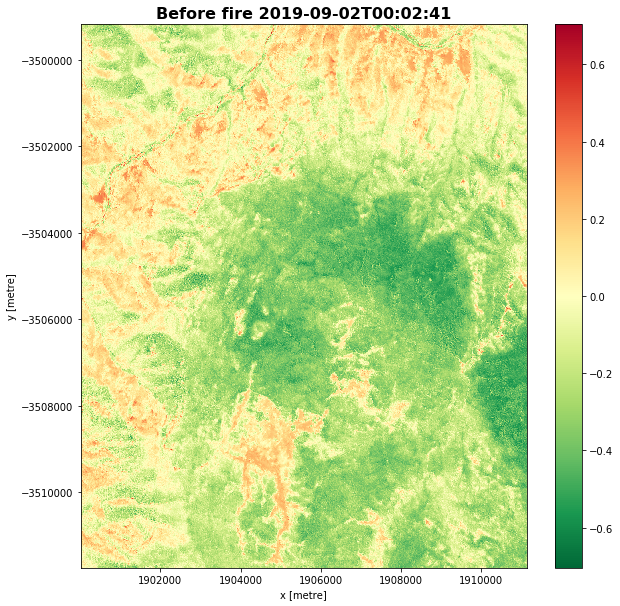

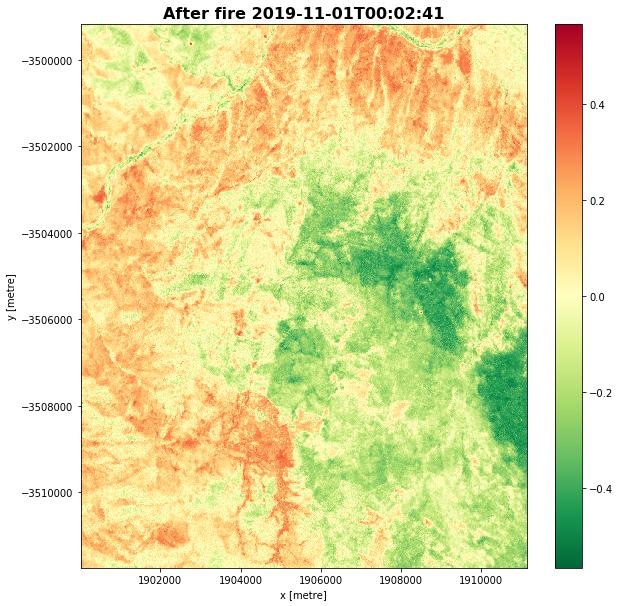

In [6]:
# Calculate the components that make up the NBR calculation
band_diff = dataset.nbar_swir_2 - dataset.nbar_nir_1
band_sum = dataset.nbar_swir_2 + dataset.nbar_nir_1

# Calculate NBR and store it as a measurement in the original dataset
nbr = band_diff / band_sum

# Set the NBR time step to view
nbr_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be burnt.
time_step = 0
plt.figure(figsize=(10, 10))
nbr.isel(time=time_step).plot(cmap="RdYlGn_r")
time_string = str(dataset.time.isel(time=time_step).values).split('.')[0] 
ax = plt.gca()
ax.set_title(f"Before fire {time_string}", fontweight='bold', fontsize=16)
plt.show()


# This is the simple way to plot
# Note that high values are likely to be burnt.
time_step = -1
plt.figure(figsize=(10, 10))
time_string = str(dataset.time.isel(time=time_step).values).split('.')[0] 
nbr.isel(time=time_step).plot(cmap="RdYlGn_r")
ax = plt.gca()
ax.set_title(f"After fire {time_string}", fontweight='bold', fontsize=16)
plt.show()

### Calculate difference

High regrowth     -  -0.50 <-0.25
Some regrowth     -  -0.25 <-0.10
Unburned          -  -0.10 < 0.10
Low severity      -   0.10 < 0.27
Mod-low severity  -   0.27 < 0.44
Mod-high severity -   0.44 < 0.66
High severity     -   0.66 < 1.30

http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio

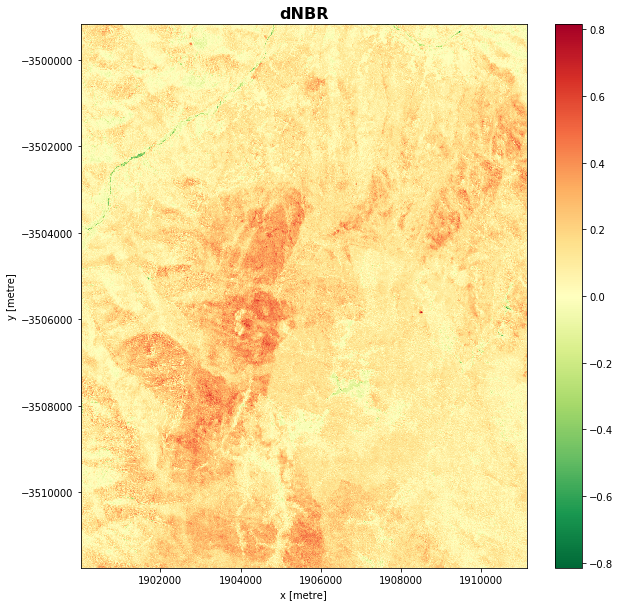

In [7]:
dnbr = nbr[-1]-nbr[0]

# This is the simple way to plot
# Note that high values are likely to be burnt.
plt.figure(figsize=(10, 10))
dnbr.plot(cmap="RdYlGn_r")
ax = plt.gca()
ax.set_title(f"dNBR", fontweight='bold', fontsize=16)
plt.show()

### Use threshold to classify

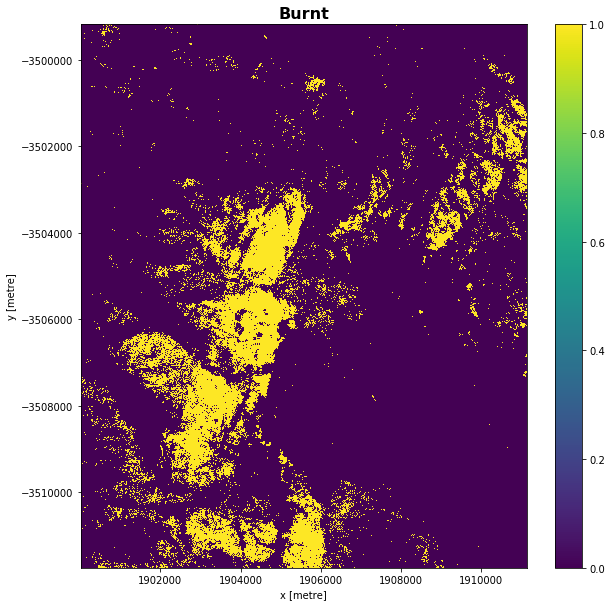

In [8]:
burnt = dnbr>0.25

# This is the simple way to plot
# Note that high values are likely to be burnt.
plt.figure(figsize=(10, 10))
burnt.plot()
ax = plt.gca()
ax.set_title(f"Burnt", fontweight='bold', fontsize=16)
plt.show()

<xarray.Dataset>
Dimensions:      (time: 11, x: 1113, y: 1257)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-02T00:02:41.024000 ... 2019-11-01T00:02:41.024000
  * y            (y) float64 -3.499e+06 -3.499e+06 ... -3.512e+06 -3.512e+06
  * x            (x) float64 1.9e+06 1.9e+06 1.9e+06 ... 1.911e+06 1.911e+06
Data variables:
    nbar_red     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbar_blue    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbar_green   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbar_nir_1   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbar_swir_2  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      epsg:3577


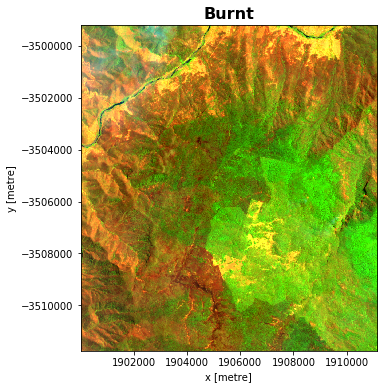

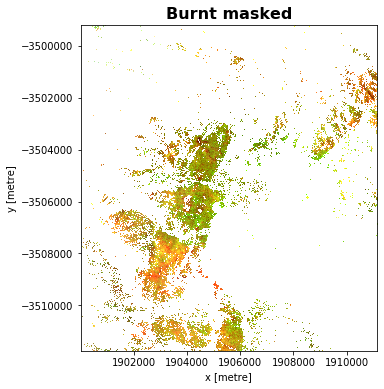

In [9]:
# Apply the burnt mask
clear = dataset.where(burnt==1)
print(clear)

ag = ['nbar_swir_2','nbar_nir_1','nbar_green']

rgb(dataset, bands=ag, index=[-1])
ax = plt.gca()
ax.set_title(f"Burnt", fontweight='bold', fontsize=16)
plt.show()

# Generate the image by running the rgb function
rgb(clear, bands=ag, index=[-1])
ax = plt.gca()
ax.set_title(f"Burnt masked", fontweight='bold', fontsize=16)
plt.show()

### Calculate area burnt

In [10]:
# Constants for calculating waterbody area
pixel_length = set_resolution[1] # in metres
print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

area_per_pixel = pixel_length**2/m_per_km**2
print(area_per_pixel)

10
0.0001


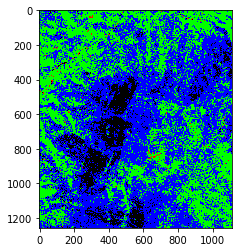

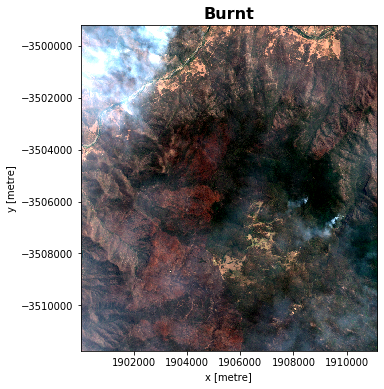

In [11]:
c1 = np.logical_and(dnbr>=-0.25,dnbr<-0.10)
c2 = np.logical_and(dnbr>=-0.10,dnbr<0.10)
c3 = np.logical_and(dnbr>=0.10,dnbr<0.27)

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
class_comp = np.dstack((c1,c2,c3)).astype(np.uint8) * 255

plt.imshow(class_comp)

rgb(dataset, bands=bands, index=[-1])
ax = plt.gca()
ax.set_title(f"Burnt", fontweight='bold', fontsize=16)
plt.show()


In [12]:
print(dataset.time.values)
print(dataset.isel(time=-1))

['2019-09-02T00:02:41.024000000' '2019-09-08T23:52:41.024000000'
 '2019-09-12T00:02:41.024000000' '2019-09-18T23:52:41.024000000'
 '2019-09-22T00:02:41.024000000' '2019-09-28T23:52:51.024000000'
 '2019-10-08T23:52:51.024000000' '2019-10-18T23:52:51.024000000'
 '2019-10-22T00:02:41.024000000' '2019-10-28T23:52:51.024000000'
 '2019-11-01T00:02:41.024000000']
<xarray.Dataset>
Dimensions:      (x: 1113, y: 1257)
Coordinates:
    time         datetime64[ns] 2019-11-01T00:02:41.024000
  * y            (y) float64 -3.499e+06 -3.499e+06 ... -3.512e+06 -3.512e+06
  * x            (x) float64 1.9e+06 1.9e+06 1.9e+06 ... 1.911e+06 1.911e+06
Data variables:
    nbar_red     (y, x) int16 832 845 859 849 865 842 ... 446 409 428 449 471
    nbar_blue    (y, x) int16 1053 1053 1040 1022 1017 ... 493 476 493 495 498
    nbar_green   (y, x) int16 945 962 941 934 941 912 ... 512 476 482 498 518
    nbar_nir_1   (y, x) int16 1428 1478 1504 1451 1493 ... 1757 1855 1785 2005
    nbar_swir_2  (y, x) int16 14

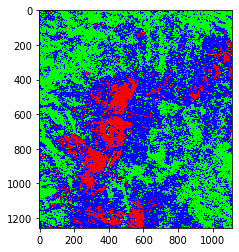

In [13]:
unburnt = dnbr<0.10
lowsev = np.logical_and(dnbr>=0.10,dnbr<0.27)
burnt = dnbr>=0.27

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
classes= np.dstack((burnt,unburnt,lowsev)).astype(np.uint8) * 255

plt.imshow(classes)


In [14]:
# Create classification
high_reg = dnbr<-0.25
some_reg = np.logical_and(dnbr>=-0.25,dnbr<-0.10)
unburnt  = np.logical_and(dnbr>=-0.10,dnbr<0.10)
low_sev  = np.logical_and(dnbr>=0.10,dnbr<0.27)
modl_sev = np.logical_and(dnbr>=0.27,dnbr<0.44)
modh_sev = np.logical_and(dnbr>=0.44,dnbr<0.66)
high_sev = dnbr>=0.66

print(high_sev)

<xarray.DataArray (y: 1257, x: 1113)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) float64 -3.499e+06 -3.499e+06 ... -3.512e+06 -3.512e+06
  * x        (x) float64 1.9e+06 1.9e+06 1.9e+06 ... 1.911e+06 1.911e+06


In [15]:
# Longer way
# Calculate area
high_reg_area = np.sum(high_reg)*area_per_pixel
some_reg_area = np.sum(some_reg)*area_per_pixel
unburnt_area  = np.sum(unburnt)*area_per_pixel
low_sev_area  = np.sum(low_sev)*area_per_pixel
modl_sev_area = np.sum(modl_sev)*area_per_pixel
modh_sev_area = np.sum(modh_sev)*area_per_pixel
high_sev_area = np.sum(high_sev)*area_per_pixel

# Print
print('high_reg_area',high_reg_area.values)
print('some_reg_area',some_reg_area.values)
print('unburnt_area',unburnt_area.values)
print('low_sev_area',low_sev_area.values)
print('modl_sev_area',modl_sev_area.values)
print('modh_sev_area',modh_sev_area.values)
print('high_sev_area',high_sev_area.values)

high_reg_area 0.1198
some_reg_area 0.7206
unburnt_area 53.1295
low_sev_area 71.9601
modl_sev_area 13.2482
modh_sev_area 0.7247
high_sev_area 0.0012000000000000001


In [16]:
# Shorter way
# Concatenate and apply area function once
class_comp = np.dstack((high_reg,some_reg,unburnt,low_sev,modl_sev,modh_sev,high_sev))#.astype(np.uint8)

x = np.sum(class_comp_area, axis = (0,1))
x

NameError: name 'class_comp_area' is not defined

### Step 5: Exporting data

In [ ]:
# You can change this, if you like.
filename = "example.tiff"

write_geotiff(dataset=dataset.isel(time=time_step), filename=filename)

### Useful Extras

In [ ]:
# Plot a histogram of values
fig = plt.figure(figsize=(15, 3))
dnbr.plot.hist(bins=1000, label="dnbr")
plt.legend()
#plt.xlabel("dnbr")
plt.title("dNBR")
plt.show()